In [1]:
from MultivariateNormalDistribution import mvn

import itertools

from scipy import linalg
from sklearn import mixture
from sklearn import metrics
from sklearn import datasets
from sklearn import utils

import numpy as np
import numpy.random as rnd
import math

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib as mpl


%matplotlib inline

In [2]:
#http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html
color_iter = itertools.cycle(['r', 'g', 'b', 'y',
                              'black'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 2, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

dimensions = 4
prior_data_size = 5
training_data_size = 45

iris = datasets.load_iris()
X = iris.data # Features
y = iris.target # Targets
# Only take part of the dimensions
X = X[:,range(0,dimensions)]
# Shuffle dataset
X, y = utils.shuffle(X,y)



# Generate training and test data for first type of iris
X_type_1 = X[y==0]
y_type_1 = y[y==0]
X_type_1_prior = np.transpose(X_type_1[range(0,prior_data_size)])
X_type_1_train = np.transpose(X_type_1[range(prior_data_size,training_data_size),:])
X_type_1_test = np.transpose(X_type_1[range(training_data_size,50),:])


X_type_2 = X[y==1]
y_type_2 = y[y==1]
X_type_2_prior = np.transpose(X_type_2[range(0,prior_data_size)])
X_type_2_train = np.transpose(X_type_2[range(prior_data_size,training_data_size),:])
X_type_2_test = np.transpose(X_type_2[range(training_data_size,50),:])

X_type_3 = X[y==2]
y_type_3 = y[y==2]
X_type_3_prior = np.transpose(X_type_3[range(0,prior_data_size)])
X_type_3_train = np.transpose(X_type_3[range(prior_data_size,training_data_size),:])
X_type_3_test = np.transpose(X_type_3[range(training_data_size,50),:])

# Generate randomized training data
#X_train = np.concatenate((X_type_1_train, X_type_2_train, X_type_3_train),axis=0)
# Generate randomized test data
print("===================== reference ================================")
mvn_ref = mvn.MultivariateNormalDistribution(dimensions=dimensions, name="reference")
mvn_ref.MLE(np.transpose(X_type_1))
print("reference mu: \n{}".format(mvn_ref.mu))


print("===================== prior 1 ================================")
mvn_prior = mvn.MultivariateNormalDistribution(dimensions=dimensions, name="prior")
mvn_prior.MLE(X_type_1_prior)
print("mu prior: \n{}".format(mvn_prior.mu))

nu0 = prior_data_size # Weight of S_0
S_0 = np.multiply(np.diag(np.diag(mvn_prior.sigma)),nu0) # Prior mean for Sigma
m_0 = mvn_prior.mu # Prior mean for mu
kappa0 = prior_data_size # Weight of m_0
print("===================== mvn 1 ================================")
mvn_1 = mvn.MultivariateNormalDistribution(dimensions=dimensions, m0=m_0, S0=S_0,kappa=kappa0, nu=nu0, name="MVN1")
# Incremental Learning
logliks = []
liks = []
for i in range(0,training_data_size-prior_data_size):
    cur_training_data = np.transpose(X_type_1_train)[0]
    #print("training_data: \n{}".format(cur_training_data.reshape(4,1)))
    mvn_1.MAP(cur_training_data.reshape(4,1))
    #print(mvn_1.mu)
    lik1 = mvn_1.likelihood(X_type_1_test)
    loglik1 = mvn_1.loglikelihood(X_type_1_test)
    print("lik1: {}".format(loglik1))
    logliks.append(loglik1)
    liks.append(lik1)
    

fig = plt.figure()
plt.subplot(211)
plt.title("Log likelihoods")
plt.xlabel("Datasets Learned")
plt.ylabel("Loglikelihood")
plt.plot(range(0,len(logliks)),logliks)
plt.subplot(212)
plt.title("Likelihoods")
plt.xlabel("Datasets Learned")
plt.ylabel("Likelihood")
plt.plot(range(0,len(liks)),liks)

#learn 
#f1 score
    

In [3]:
def predictOutcome(data, y, mvn_list):
    out = []
    for i in range(0,len(data)):
        cur = np.transpose(data[i].reshape(1,4))
        logliks = []
        for m in mvn_list:
            if m.updatedPrior: # In the beginning not all mvns are updated using MAP thats why we have to check
                logliks.append(m.logPosteriorPredictive(cur))
            else:
                logliks.append(0)
        out.append(logliks.index(max(logliks)))
    #print("===done===")
    return out

[[5.1 4.9 4.7 4.6 5.  5.4]
 [3.5 3.  3.2 3.1 3.6 3.9]
 [1.4 1.4 1.3 1.5 1.4 1.7]
 [0.2 0.2 0.2 0.2 0.2 0.4]]
===================== prior 1 ================================
mu prior 1: 
[[4.95      ]
 [3.38333333]
 [1.45      ]
 [0.23333333]]
===================== prior 2 ================================
mu prior 2: 
[[6.33333333]
 [2.9       ]
 [4.53333333]
 [1.41666667]]
===================== prior 3 ================================
mu prior 3: 
[[6.6       ]
 [2.98333333]
 [5.83333333]
 [2.1       ]]
===================== mvn 1-3 with prior ================================
===================== Interactive Learning ================================


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


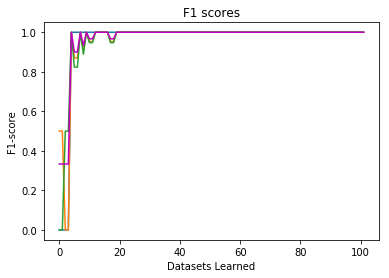

In [5]:
dimensions = 4
prior_data_size = 6
training_data_size = 40

iris = datasets.load_iris()
X = iris.data # Features 
y = iris.target # Targets
# Only take part of the dimensions
X = X[:,range(0,dimensions)]

# Generate training and test data for first type of iris
X_type_1 = X[y==0]
y_type_1 = y[y==0]
X_type_1_prior = np.transpose(X_type_1[range(0,prior_data_size)])
print(X_type_1_prior)
X_type_1_train = np.transpose(X_type_1[range(prior_data_size,training_data_size),:])
X_type_1_test = np.transpose(X_type_1[range(training_data_size,50),:])
y_type_1_test = y_type_1[range(training_data_size,50)]
# Generate training and test data for first type of iris
X_type_2 = X[y==1]
y_type_2 = y[y==1]
X_type_2_prior = np.transpose(X_type_2[range(0,prior_data_size)])
X_type_2_train = np.transpose(X_type_2[range(prior_data_size,training_data_size),:])
X_type_2_test = np.transpose(X_type_2[range(training_data_size,50),:])
y_type_2_test = y_type_2[range(training_data_size,50)]
# Generate training and test data for first type of iris
X_type_3 = X[y==2]
y_type_3 = y[y==2]
X_type_3_prior = np.transpose(X_type_3[range(0,prior_data_size)])
X_type_3_train = np.transpose(X_type_3[range(prior_data_size,training_data_size),:])
X_type_3_test = np.transpose(X_type_3[range(training_data_size,50),:])
y_type_3_test = y_type_3[range(training_data_size,50)]
print("===================== prior 1 ================================")
mvn_prior_1 = mvn.MultivariateNormalDistribution(dimensions=dimensions, name="prior1")
mvn_prior_1.MLE(X_type_1_prior)
print("mu prior 1: \n{}".format(mvn_prior_1.mu))
print("===================== prior 2 ================================")
mvn_prior_2 = mvn.MultivariateNormalDistribution(dimensions=dimensions, name="prior2")
mvn_prior_2.MLE(X_type_2_prior)
print("mu prior 2: \n{}".format(mvn_prior_2.mu))
print("===================== prior 3 ================================")
mvn_prior_3 = mvn.MultivariateNormalDistribution(dimensions=dimensions, name="prior3")
mvn_prior_3.MLE(X_type_3_prior)
print("mu prior 3: \n{}".format(mvn_prior_3.mu))

print("===================== mvn 1-3 with prior ================================")
nu0 = dimensions+2;
# Check diag, some problem with calculating S_0 in mvtshfhdfahjdf
S_0 = np.identity(4)#np.multiply(np.diag(np.diag(mvn_prior_1.sigma)),nu0)
m_0 = np.zeros((4,1))#mvn_prior_1.mu
kappa0 = 0.01#prior_data_size
mvn_type_1 = mvn.MultivariateNormalDistribution(dimensions=dimensions, m0=m_0, S0=S_0 , kappa=kappa0, nu=nu0, name="MVN1")
S_0 = np.identity(4)#np.multiply(np.diag(np.diag(mvn_prior_2.sigma)),nu0)
m_0 = np.zeros((4,1))#mvn_prior_2.mu
kappa0 = 0.01#prior_data_size
mvn_type_2 = mvn.MultivariateNormalDistribution(dimensions=dimensions, m0=m_0, S0=S_0 , kappa=kappa0, nu=nu0, name="MVN2")
S_0 = np.identity(4)#np.multiply(np.diag(np.diag(mvn_prior_3.sigma)),nu0)
m_0 = np.zeros((4,1))#mvn_prior_3.mu
kappa0 = 0.01#prior_data_size
mvn_type_3 = mvn.MultivariateNormalDistribution(dimensions=dimensions, m0=m_0, S0=S_0 , kappa=kappa0, nu=nu0, name="MVN3")

print("===================== Interactive Learning ================================")

X_train = np.concatenate((np.transpose(X_type_1_train),np.transpose(X_type_2_train),np.transpose(X_type_3_train)),axis=0)
X_test = np.concatenate((np.transpose(X_type_1_test),np.transpose(X_type_2_test),np.transpose(X_type_3_test)),axis=0)
y_train = np.concatenate((y_type_1[range(prior_data_size,training_data_size)],y_type_2[range(prior_data_size,training_data_size)],y_type_3[range(prior_data_size,training_data_size)]),axis=0)
y_test = np.concatenate((y_type_1_test, y_type_2_test, y_type_3_test),axis=0)

X_train, y_train = utils.shuffle(X_train,y_train)

# Incrementally learn the 3 mvns and Calculate f1 score by using the test 
# set to see which y_tests are correct and which are not
f1_1 = []
f1_2 = []
f1_3 = []
f1_list = []
for i in range(0,len(X_train)):
    if y_train[i] == 0:
        mvn_type_1.MAP(np.transpose(X_train[i].reshape(1,4)))
    elif y_train[i] == 1:
        mvn_type_2.MAP(np.transpose(X_train[i].reshape(1,4)))
    elif y_train[i] == 2:
        mvn_type_3.MAP(np.transpose(X_train[i].reshape(1,4)))
    # Test and calculate f1 scores
    y_pred = predictOutcome(X_test, y_test,[mvn_type_1,mvn_type_2,mvn_type_3])
    f1 = metrics.f1_score(y_test, y_pred, average=None)
    f1_1.append(f1[0])
    f1_2.append(f1[1])
    f1_3.append(f1[2])
    f1_list.append(metrics.f1_score(y_test, y_pred, average='micro'))

x_tick = range(0,len(f1_1))

fig = plt.figure()
plt.subplot(111)
plt.title("F1 scores")
plt.xlabel("Datasets Learned")
plt.ylabel("F1-score")
plt.plot(x_tick,f1_1)
plt.plot(x_tick,f1_2)
plt.plot(x_tick,f1_3)
plt.plot(x_tick,f1_list,color='m')

# plot ellipsoids for all dimensions